In [1]:
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt

import time
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


2024-05-29 03:25:26.102557: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 03:25:26.102702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 03:25:26.367936: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install split-folders
!pip install visualkeras
import visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 6.2 MB/s eta 0:00:00a 0:00:01m


In [3]:
import splitfolders 
import visualkeras
splitfolders.ratio("/kaggle/input/new-bangladeshi-crop-disease/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Rice", 
                   output="padi-data", 
                   seed=42, 
                   ratio=(.8, .1, .1), 
                   group_prefix=None) 

Copying files: 4078 files [01:00, 67.19 files/s] 


In [4]:
training_dir = os.path.join('padi-data', 'train')
testing_dir = os.path.join('padi-data', 'test')
validating_dir = os.path.join('padi-data', 'val')

In [5]:
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    training_dir,
    shuffle=True,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
    validating_dir,
    target_size=(224,224),
    shuffle=True,
    class_mode='categorical',
    batch_size=32
)

testing_generator = validation_datagen.flow_from_directory(
    testing_dir,
    target_size=(224, 224),
    shuffle=True,
    class_mode='categorical',
    batch_size=32
)

Found 3261 images belonging to 4 classes.
Found 406 images belonging to 4 classes.
Found 411 images belonging to 4 classes.


In [6]:
class_indices = train_generator.class_indices
print(class_indices)
class_names = list(class_indices.keys())
print(class_names)
class_count = len(class_names)

{'Rice___Brown_Spot': 0, 'Rice___Healthy': 1, 'Rice___Leaf_Blast': 2, 'Rice___Neck_Blast': 3}
['Rice___Brown_Spot', 'Rice___Healthy', 'Rice___Leaf_Blast', 'Rice___Neck_Blast']


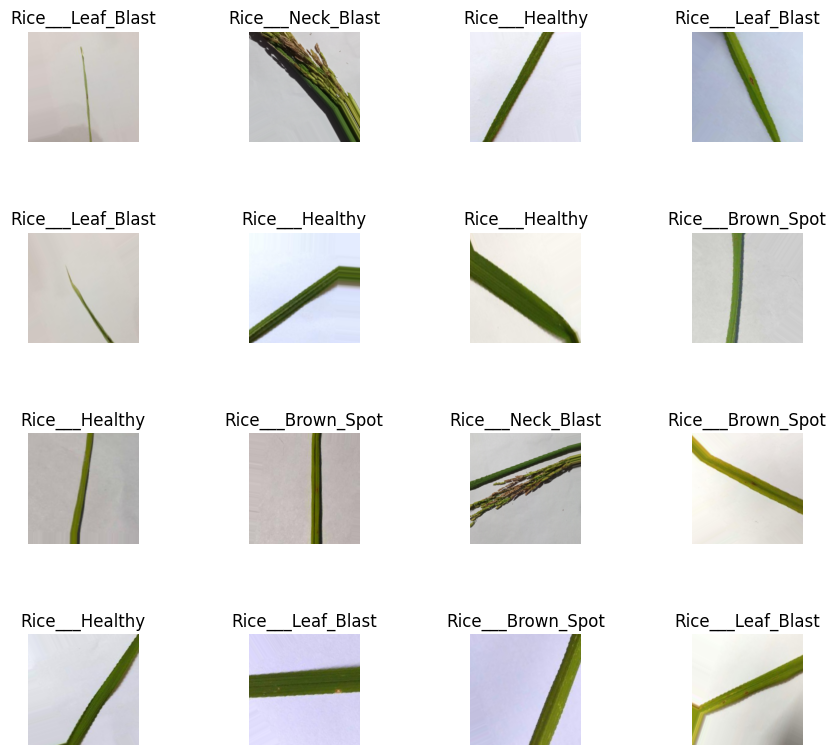

In [7]:
def display_images(images, labels, class_indices):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        label_index = np.argmax(labels[i])
        label = list(class_indices.keys())[list(class_indices.values()).index(label_index)]
        ax.set_title(label)
        plt.subplots_adjust(wspace=1)
        ax.axis('off')

train_images, train_labels = next(train_generator)
display_images(train_images, train_labels, train_generator.class_indices)
plt.show()

In [13]:
# class LR_ASK(keras.callbacks.Callback):
#     def __init__(self, total_epochs, ask_epoch):
#         super(LR_ASK, self).__init__()
#         self.ask_epoch = ask_epoch
#         self.total_epochs = total_epochs
#         self.ask = True
#         self.lowest_val_loss = np.inf
#         self.best_weights = None
#         self.best_epoch = 1

#     def on_train_begin(self, logs=None):
#         if self.ask_epoch == 0:
#             print('You set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
#             self.ask_epoch = 1
#         if self.ask_epoch >= self.total_epochs:
#             print('ask_epoch >= total_epochs, will train for', self.total_epochs, 'epochs', flush=True)
#             self.ask = False
#         if self.total_epochs == 1:
#             self.ask = False
#         else:
#             print('Training will proceed until epoch', self.ask_epoch, 'then you will be asked to')
#             print('enter H to halt training or enter an integer for how many more epochs to run then be asked again')
#         self.start_time = time.time()

#     def on_train_end(self, logs=None):
#         if self.best_weights is not None:
#             print('Loading model with weights from epoch', self.best_epoch)
#             self.model.set_weights(self.best_weights)
#         training_duration = time.time() - self.start_time
#         hours = training_duration // 3600
#         minutes = (training_duration - (hours * 3600)) // 60
#         seconds = training_duration - ((hours * 3600) + (minutes * 60))
#         msg = f'Training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds'
#         print(msg, flush=True)

#     def on_epoch_end(self, epoch, logs=None):
#         val_loss = logs.get('val_loss')
#         if val_loss is not None and val_loss < self.lowest_val_loss:
#             self.lowest_val_loss = val_loss
#             self.best_weights = self.model.get_weights()
#             self.best_epoch = epoch + 1
#             print(f'\nValidation loss of {val_loss:7.4f} is below the lowest loss, saving weights from epoch {str(epoch + 1):3s} as the best weights')
#         else:
#             print(f'\nValidation loss of {val_loss:7.4f} is above the lowest loss of {self.lowest_val_loss:7.4f}, keeping weights from epoch {str(self.best_epoch)} as the best weights')

#         if self.ask:
#             if epoch + 1 == self.ask_epoch:
#                 print('\nDo you want to continue training (Y/N)?')
#                 ans = input()

#                 if ans.lower() == 'n':
#                     print('Training halted on epoch', epoch + 1, 'due to user input\n', flush=True)
#                     self.model.stop_training = True
#                 else:
#                     self.ask_epoch += 1

In [26]:
class myCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        if acc is not None and val_acc is not None and acc > 0.96 and val_acc > 0.96:
            self.model.stop_training = True

In [27]:
tf.keras.backend.clear_session()

from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

image_shape = (224, 224, 3)
model_name = 'MobileNet'
base_model = MobileNet(
    include_top=False,
    input_shape=image_shape,
    pooling=None,  # Remove the pooling parameter
    weights='imagenet',

)
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 60

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate=0.2)(x)

output = Dense(class_count, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)
model.summary()



Number of layers in the base model:  86


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,282,564 (16.34 MB)

 Trainable params: 3,185,156 (12.15 MB)

 Non-trainable params: 1,097,408 (4.19 MB)

In [28]:
rlp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

# COMPILE MODEL HERE
callbacks = myCallback()

In [29]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

total_epochs = 100
# ask_epoch = 25
# ask_callback = LR_ASK(total_epochs, ask_epoch)  # Hanya mengirim 2 argumen, bukan 3
# rlronp_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1)
# earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, verbose=1)
# callbacks = [rlronp_callback, ask_callback, earlystop_callback]

In [30]:
training_history = model.fit(train_generator,
                             epochs=total_epochs,
                             verbose=1,
                             callbacks=[rlp, callbacks],
                             validation_data=validation_generator,
                             validation_steps=len(validation_generator),
                             initial_epoch=0)

Epoch 1/100
  2/102 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.1797 - loss: 2.6170  

W0000 00:00:1716955808.333958     150 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 85/102 ━━━━━━━━━━━━━━━━━━━━ 15s 926ms/step - accuracy: 0.6031 - loss: 1.3857

W0000 00:00:1716955885.962326     152 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 862ms/step - accuracy: 0.6199 - loss: 1.2938

W0000 00:00:1716955899.451568     150 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


102/102 ━━━━━━━━━━━━━━━━━━━━ 117s 985ms/step - accuracy: 0.6208 - loss: 1.2891 - val_accuracy: 0.4704 - val_loss: 3.5302 - learning_rate: 0.0010
Epoch 2/100


W0000 00:00:1716955907.791529     150 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


102/102 ━━━━━━━━━━━━━━━━━━━━ 92s 845ms/step - accuracy: 0.7799 - loss: 0.5314 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 100s 924ms/step - accuracy: 0.8099 - loss: 0.4908 - val_accuracy: 0.8202 - val_loss: 0.5272 - learning_rate: 0.0010
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 90s 824ms/step - accuracy: 0.8179 - loss: 0.4724 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 100s 911ms/step - accuracy: 0.8301 - loss: 0.4407 - val_accuracy: 0.8424 - val_loss: 0.3805 - learning_rate: 0.0010
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 91s 824ms/step - accuracy: 0.8442 - loss: 0.4156 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 100s 913ms/step - accuracy: 0.8435 - loss: 0.4149 - val_accuracy: 0.7783 - val_loss: 0.6157 - learning_rate: 0.0010
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 91s 824m

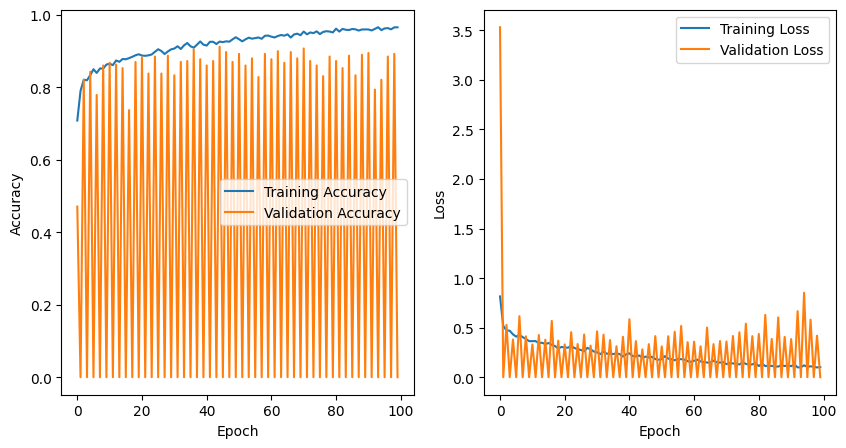

In [37]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(training_history.history['accuracy'], label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [38]:
score = model.evaluate(testing_generator, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 731ms/step - accuracy: 0.8468 - loss: 0.7222
Test loss: 0.7656042575836182 / Test accuracy: 0.8588807582855225


In [40]:
model.save('padie.h5')